In [3]:
import pandas as pd
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [4]:
# Load dataset
df = pd.read_csv('data/CreditCardFraudFourYears.csv', index_col=0)
df.head(1)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,39.7564,...,79fc4fa0f0cd9659311b2d49cfe4a4fc,2019-11-07,03:40:47,1573116047,grocery_pos,339.8,1,fraud_Bradtke PLC,39.817013,-76.261575


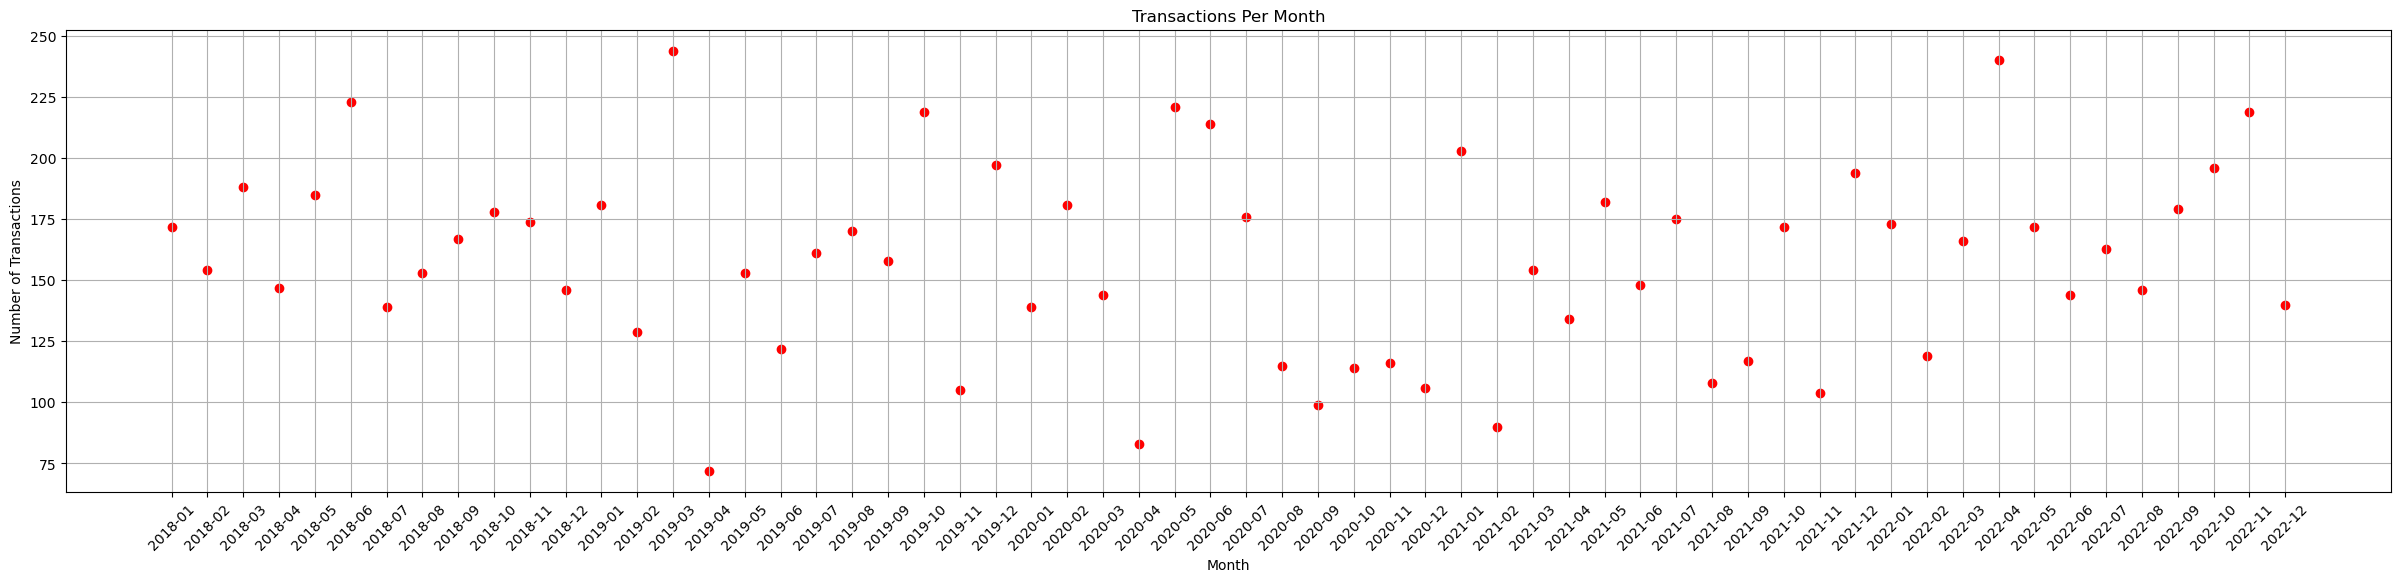

In [5]:
# Convert 'trans_date' to datetime format
df['trans_date'] = pd.to_datetime(df['trans_date'])

# Create a new column for the month
df['trans_month'] = df['trans_date'].dt.to_period('M')

# Group by month and count the number of transactions
monthly_transactions = df.groupby('trans_month').size()

monthly_transactions = df[df['is_fraud'] == 1].groupby('trans_month').size()

# Rename the series
monthly_transactions = monthly_transactions.rename('total_transactions')

# Reset index to make 'trans_month' a column instead of the index
monthly_transactions = monthly_transactions.reset_index()

plt.figure(figsize=(30, 6))
plt.scatter(monthly_transactions['trans_month'].astype(str), monthly_transactions['total_transactions'], color='red')
plt.title('Transactions Per Month')
plt.xlabel('Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

In [13]:
#df['trans_month'] = df['trans_date'].dt.to_period('Q')


In [7]:
monthly_transactions.head()

,trans_month,total_transactions
0,2018-01,172
1,2018-02,154
2,2018-03,188
3,2018-04,147
4,2018-05,185


In [14]:
daily_transactions = df.groupby('trans_date').size()
daily_transactions.index = pd.to_datetime(daily_transactions.index)
monthly_transactions = daily_transactions.groupby(pd.Grouper(freq='MS')).sum()
monthly_transactions = monthly_transactions.reset_index()
monthly_transactions = monthly_transactions.rename(columns={'trans_date': 'trans_month', 0: 'total_transactions'})

In [17]:
monthly_transactions['trans_month'] = pd.to_datetime(monthly_transactions['trans_month'])
monthly_transactions.set_index('trans_month', inplace=True)
monthly_transactions.head()

,total_transactions
trans_month,
2018-01-01,45218
2018-02-01,41033
2018-03-01,62296
2018-04-01,58907
2018-05-01,63069


# Seasonal Decompose

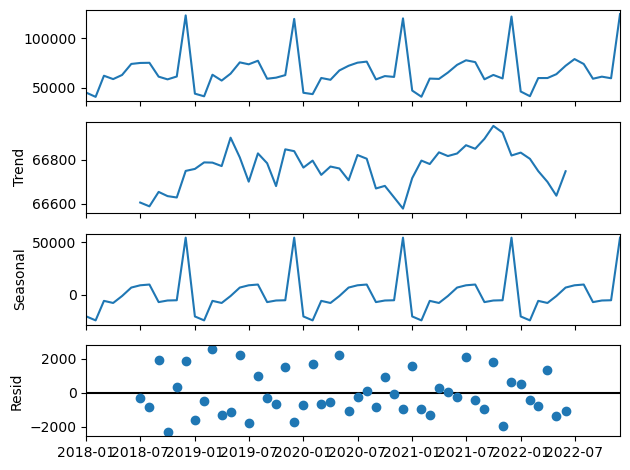

In [18]:
result = seasonal_decompose(monthly_transactions, model='add')
result.plot();

## Parameters m=12

In [19]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(monthly_transactions,seasonal=True,m=12).summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -424.900
Date:                  Mon, 08 Apr 2024   AIC                            851.800
Time:                          14:34:21   BIC                            853.671
Sample:                      01-01-2018   HQIC                           852.507
                           - 12-01-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.833e+06   7.49e+05      3.781      0.000    1.36e+06     4.3e+06
===================================================================================
Ljung-Box (L1) (Q):                  11.60   Jarque-Bera (JB):                 2.27
Prob(Q):                              0.00   Prob(JB):                         0.32
Heteroskedasticity (H):               0.51   Skew:                            -0.36
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets

In [20]:
len(monthly_transactions)

60

In [21]:
# Set one month for testing - imporant - use the latest data for the best forecasting
train = monthly_transactions.iloc[:30]
test = monthly_transactions.iloc[30:]
print(len(train))
print(len(test))

30
30


### Train

In [22]:
#monthly model because season = month => m=12
#monthly_model = SARIMAX(train,seasonal_order=(0,1,0,12))
monthly_model = SARIMAX(train,seasonal_order=(0,1,0,12))
monthly_results = monthly_model.fit()
monthly_results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74363D+01    |proj g|=  2.22546D+01

At iterate    5    f=  5.42951D+00    |proj g|=  1.01700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      1     0     0   1.017D-04   5.430D+00
  F =   5.4295140721883799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 total_transactions   No. Observations:                   30
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -162.885
Date:                            Mon, 08 Apr 2024   AIC                            329.771
Time:                                    14:34:21   BIC                            331.552
Sample:                                01-01-2018   HQIC                           330.016
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0145      0.089     -0.163      0.871      -0.189       0.160
sigma2      3.185e+06   1.26e+06      2.531      0.011    7.19e+05    5.65e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.92   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.03   Prob(JB):                         0.45
Heteroskedasticity (H):               4.91   Skew:                            -0.57
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predict

In [23]:
# Obtain predicted values
start=len(train)+1
end=len(train)+len(test)
print(start, end, end-start)

31 60 29


In [24]:
monthly_predictions = monthly_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0,12) Predictions')
monthly_predictions.head()

2020-08-01     77392.282408
2020-09-01     59278.010381
2020-10-01     60352.999850
2020-11-01     62909.000002
2020-12-01    119509.000000
Freq: MS, Name: SARIMA(0,1,0,12) Predictions, dtype: float64

In [25]:
monthly_predictions.tail()

2022-09-01     59278.010381
2022-10-01     60352.999850
2022-11-01     62909.000002
2022-12-01    119509.000000
2023-01-01     45131.000000
Freq: MS, Name: SARIMA(0,1,0,12) Predictions, dtype: float64

In [26]:
print(len(test))
print(len(monthly_predictions))

30
30


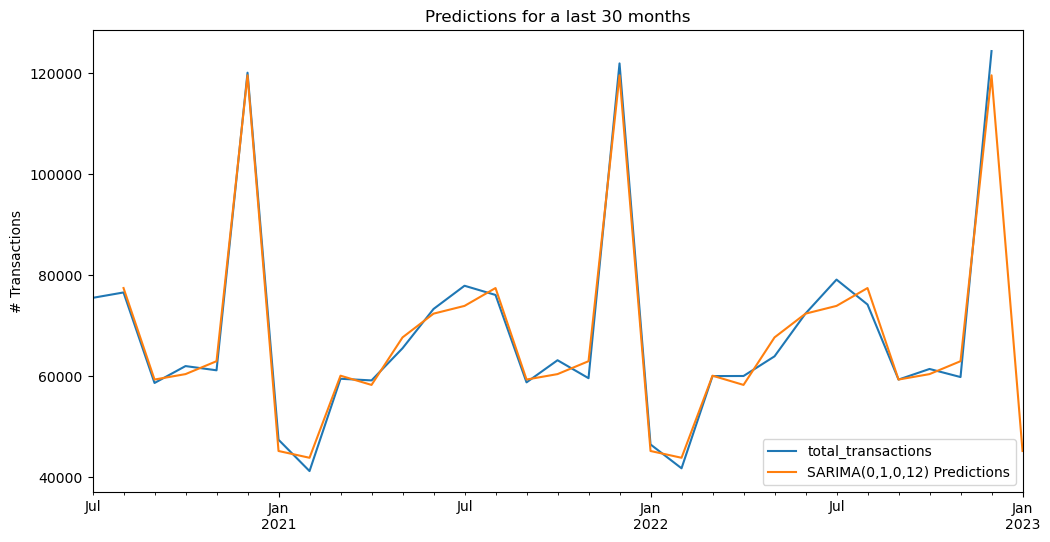

In [27]:
# Plot predictions against known values
title = 'Predictions for a last 30 months'
ylabel='# Transactions'
xlabel=''

#ax = test.plot(legend=True,figsize=(12,6),title=title)
ax = monthly_transactions[30:].plot(legend=True,figsize=(12,6),title=title)
monthly_predictions.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate model

In [28]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, monthly_predictions)
print(f'SARIMA(0,1,0,12) MSE Error: {error:11.10}')

SARIMA(0,1,0,12) MSE Error: 1.004165495e+09


In [29]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test, monthly_predictions)
mean_error = np.mean(error)
print(f'SARIMA Mean RMSE Error: {mean_error:11.10f}')

SARIMA Mean RMSE Error: 26621.2880592965


### Forecast the future

** RETRAIN ON ALL DATA **

In [30]:
model = SARIMAX(monthly_transactions,seasonal_order=(0,1,0,12))  
results = monthly_model.fit()
fcast = results.predict(len(monthly_transactions),len(monthly_transactions)+12,typ='levels').rename('SARIMA(0,1,0,12) Forecast')
# forecasting for 12 months

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74363D+01    |proj g|=  2.22546D+01

At iterate    5    f=  5.42951D+00    |proj g|=  1.01700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      1     0     0   1.017D-04   5.430D+00
  F =   5.4295140721883799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


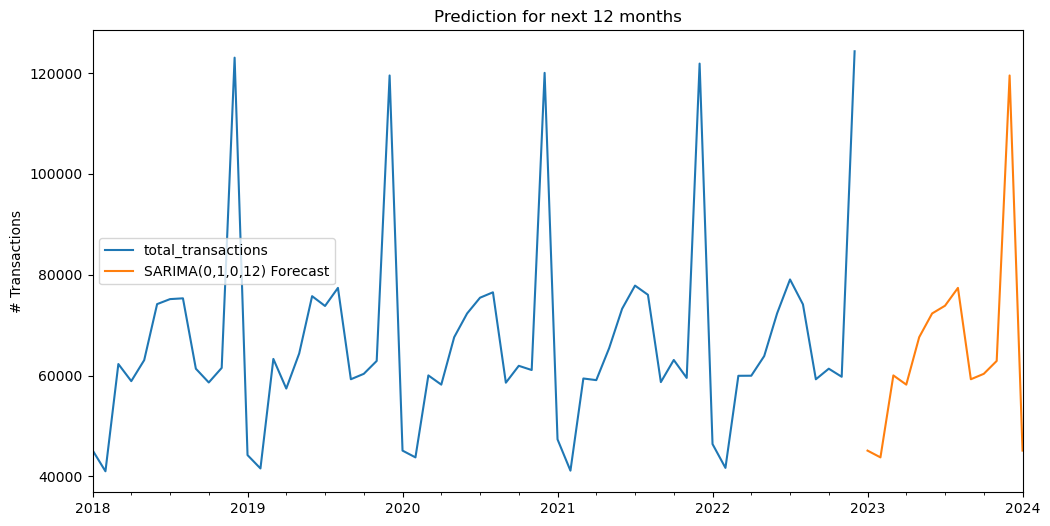

In [31]:
# Plot predictions against known values
title = 'Prediction for next 12 months'
ylabel='# Transactions'
xlabel=''

ax = monthly_transactions.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors - SARIMAX

Adding in a useful external feature
SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous factors. It is an extension of the seasonal ARIMA (SARIMA) model that allows for the inclusion of additional exogenous variables, also known as covariates or regressors, in the forecasting process.

The SARIMAX model incorporates both the seasonal and non-seasonal components of ARIMA, while also considering the impact of external factors on the time series being forecasted. These external factors could be other time series variables, indicators, or predictors that may influence the target variable.

The general equation for a SARIMAX(p, d, q)(P, D, Q)s model with \( k \) exogenous variables can be expressed as:

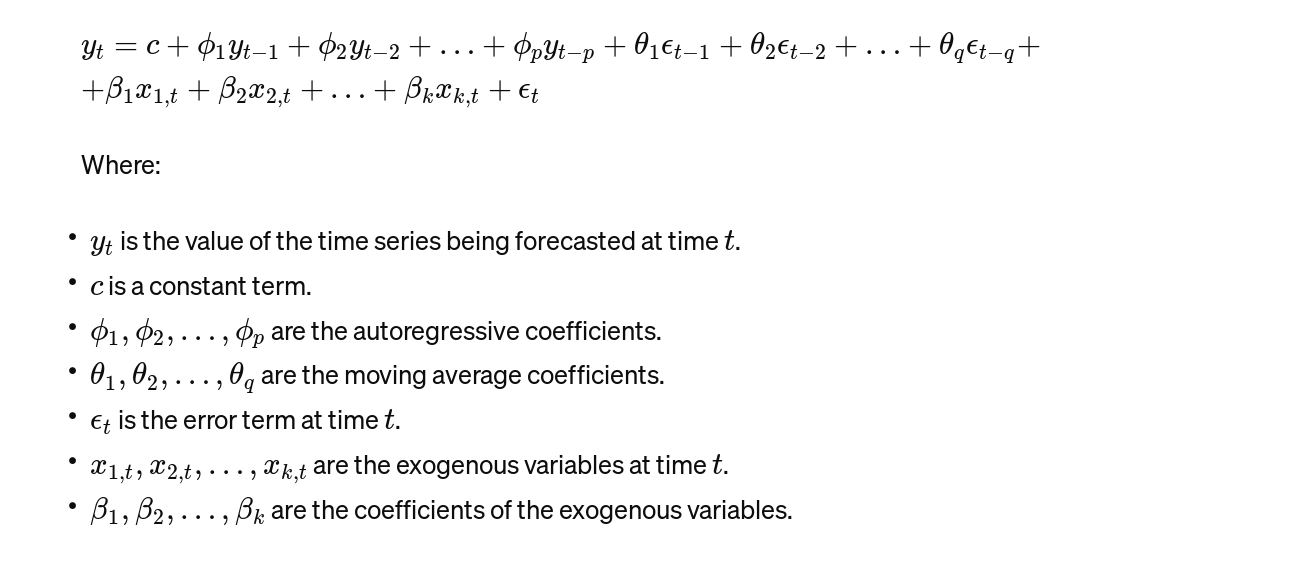

SARIMAX models are useful when there are known external factors that can improve the forecasting accuracy of the time series of interest. These external variables can capture additional information not accounted for by the ARIMA components alone, leading to more accurate predictions.

Estimation and inference in SARIMAX models involve fitting the model parameters, including both the ARIMA and exogenous variables coefficients, typically using maximum likelihood estimation or other optimization techniques. These models can be particularly powerful in scenarios where the behavior of the time series is influenced by both internal dynamics and external factors.

# Extra Feature: Month

In [32]:
df = pd.read_csv('data/CreditCardFraudFourYears.csv', index_col=0)
df.head(1)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,39.7564,...,79fc4fa0f0cd9659311b2d49cfe4a4fc,2019-11-07,03:40:47,1573116047,grocery_pos,339.8,1,fraud_Bradtke PLC,39.817013,-76.261575


In [33]:
df['trans_date'] = pd.to_datetime(df['trans_date'])

# Create a new column for the month
df['trans_month'] = df['trans_date'].dt.to_period('M')

# Group by month and count the number of transactions
monthly_transactions = df.groupby('trans_month').size()

# Rename the series
monthly_transactions = monthly_transactions.rename('total_transactions')

# Reset index to make 'trans_month' a column instead of the index
monthly_transactions = monthly_transactions.reset_index()
monthly_transactions.head(1)

,trans_month,total_transactions
0,2018-01,45218


In [34]:
daily_transactions = df.groupby('trans_date').size()
daily_transactions.index = pd.to_datetime(daily_transactions.index)
monthly_transactions = daily_transactions.groupby(pd.Grouper(freq='MS')).sum()
monthly_transactions = monthly_transactions.reset_index()
monthly_transactions = monthly_transactions.rename(columns={'trans_date': 'trans_month', 0: 'total_transactions'})
monthly_transactions.head(1)

,trans_month,total_transactions
0,2018-01-01,45218


In [35]:
monthly_transactions['trans_month'] = pd.to_datetime(monthly_transactions['trans_month'])
monthly_transactions['month'] = monthly_transactions['trans_month'].dt.month
monthly_transactions.head(1)

,trans_month,total_transactions,month
0,2018-01-01,45218,1


In [36]:
monthly_transactions['trans_month'] = pd.to_datetime(monthly_transactions['trans_month'])
monthly_transactions.set_index('trans_month', inplace=True)
monthly_transactions.head()

,total_transactions,month
trans_month,,
2018-01-01,45218,1
2018-02-01,41033,2
2018-03-01,62296,3
2018-04-01,58907,4
2018-05-01,63069,5


In [37]:
#monthly_transactions.index.freq = 'MS'

[Text(0.5, 0, ''), Text(0, 0.5, 'Transactions per day')]

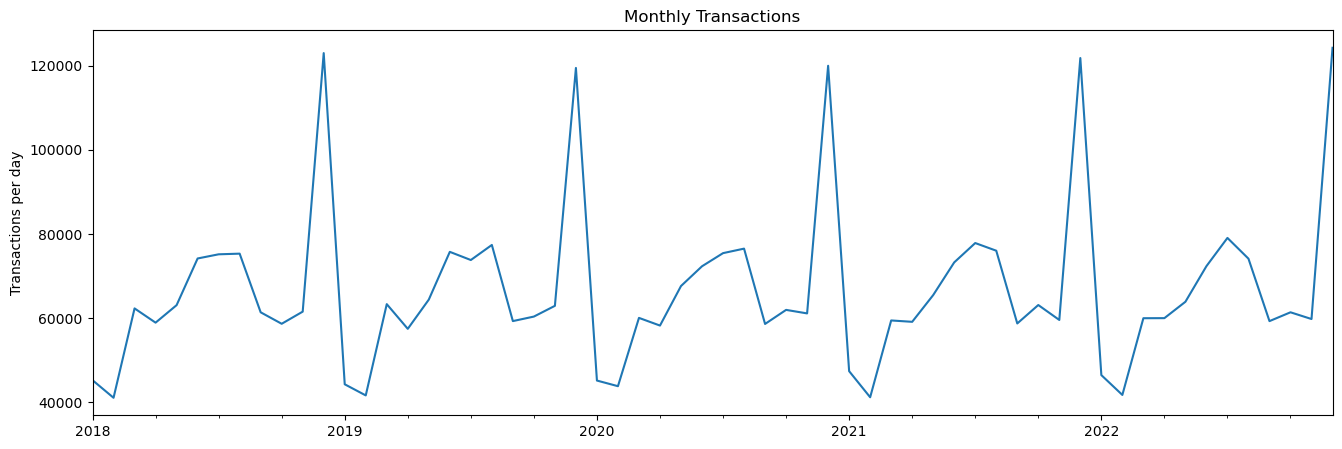

In [38]:
title='Monthly Transactions'
ylabel='Transactions per day'
xlabel='' # we don't really need a label here
ax = monthly_transactions['total_transactions'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


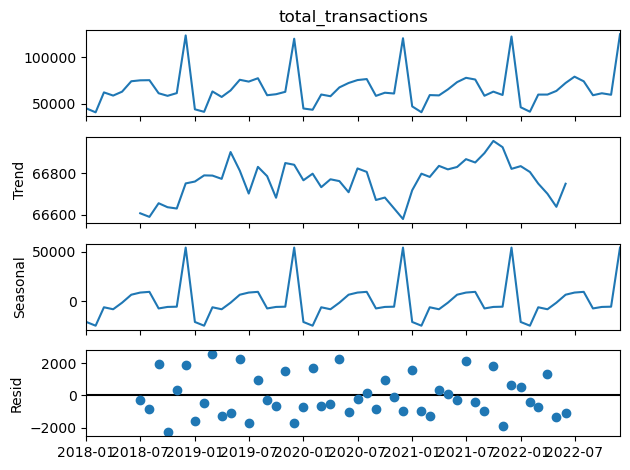

In [39]:
result = seasonal_decompose(monthly_transactions['total_transactions'])
result.plot();

### Forecast the future

In [40]:
auto_arima(monthly_transactions['total_transactions'],seasonal=True,m=12).summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -424.900
Date:                  Mon, 08 Apr 2024   AIC                            851.800
Time:                          14:34:45   BIC                            853.671
Sample:                      01-01-2018   HQIC                           852.507
                           - 12-01-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.833e+06   7.49e+05      3.781      0.000    1.36e+06     4.3e+06
===================================================================================
Ljung-Box (L1) (Q):                  11.60   Jarque-Bera (JB):                 2.27
Prob(Q):                              0.00   Prob(JB):                         0.32
Heteroskedasticity (H):               0.51   Skew:                            -0.36
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
train = monthly_transactions.iloc[:30]
test = monthly_transactions.iloc[30:]
print(len(train))
print(len(test))

30
30


In [42]:
monthly_model = SARIMAX(train['total_transactions'],seasonal_order=(0,1,0,12))
monthly_results = monthly_model.fit()
monthly_results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74363D+01    |proj g|=  2.22546D+01

At iterate    5    f=  5.42951D+00    |proj g|=  1.01700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      1     0     0   1.017D-04   5.430D+00
  F =   5.4295140721883799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 total_transactions   No. Observations:                   30
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -162.885
Date:                            Mon, 08 Apr 2024   AIC                            329.771
Time:                                    14:34:45   BIC                            331.552
Sample:                                01-01-2018   HQIC                           330.016
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0145      0.089     -0.163      0.871      -0.189       0.160
sigma2      3.185e+06   1.26e+06      2.531      0.011    7.19e+05    5.65e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.92   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.03   Prob(JB):                         0.45
Heteroskedasticity (H):               4.91   Skew:                            -0.57
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
results = monthly_model.fit()
fcast = results.predict(len(monthly_transactions),len(monthly_transactions)+12,typ='levels').rename('SARIMA(0,1,0,12) Forecast')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74363D+01    |proj g|=  2.22546D+01

At iterate    5    f=  5.42951D+00    |proj g|=  1.01700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      1     0     0   1.017D-04   5.430D+00
  F =   5.4295140721883799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


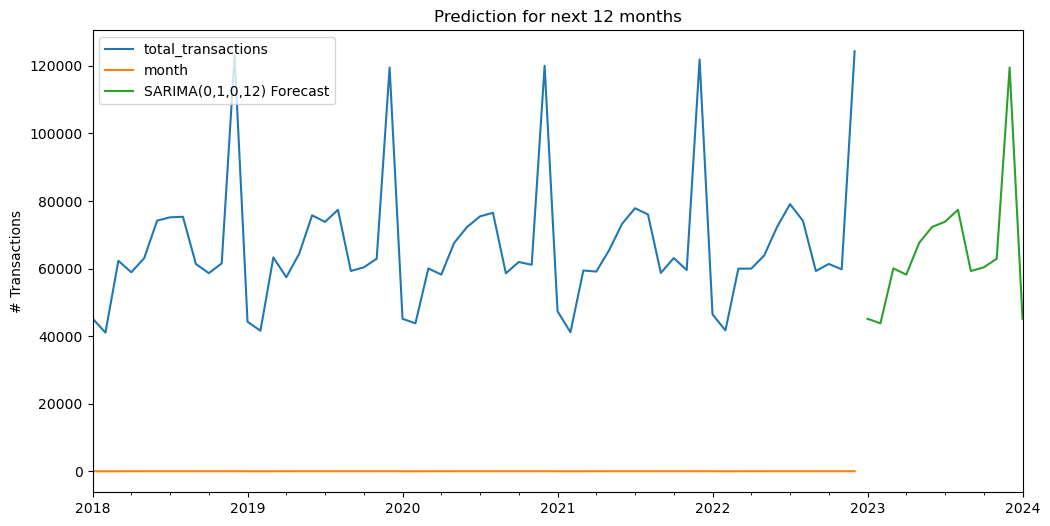

In [44]:
title = 'Prediction for next 12 months'
ylabel='# Transactions'
xlabel=''

ax = monthly_transactions.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Evaluate without the extra feature

## Add in extra featuer - Month

In [46]:
exog_forecast = monthly_transactions[['month']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

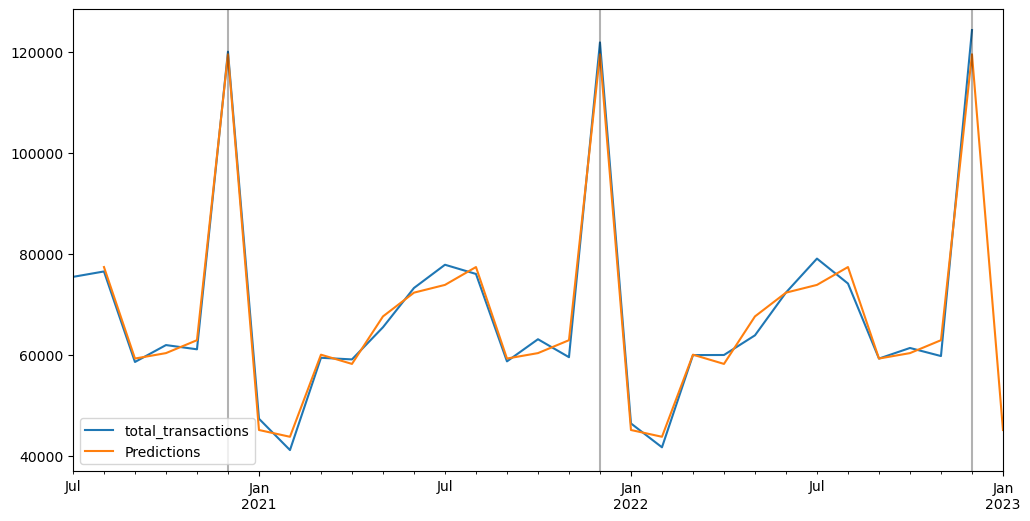

In [47]:
# Plot predictions against known values
title=''
ylabel=''
xlabel=''

ax = test['total_transactions'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('month==12').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

## Evaluate with the new feature

In [49]:
from statsmodels.tools.eval_measures import mse,rmse
error1x = mse(test['total_transactions'], predictions)
error2x = rmse(test['total_transactions'], predictions)

# Print new SARIMAX values
print(f'With Feature -  MSE Error: {error1x:11.10}')
print(f'With Feature -  RMSE Error: {error2x:11.10}')

With Feature -  MSE Error: 1.004165495e+09
With Feature -  RMSE Error: 31688.57042
